In [2]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
import os

Nchunk = 20
trials = 1e4
directory = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_03_intermediate/' 
os.system('mkdir %spng' %directory)
nfolder = 'tesi_intermediate_nominal_EBL/'
dfolder = 'tesi_intermediate_degraded_EBL/'
folders = [nfolder, dfolder]

texp = [5,10,100]
sigma = [5]
chunk = [i+1 for i in range(Nchunk)]
csvName = [[]*i for i in range(len(texp))]

for i, f in enumerate(folders):
    path = directory + f + '/run0406/run0406_ID000126/csv/'

    for i in range(len(chunk)) :  
        for j in range(len(texp)) :
            csvName[j].append('run0406_%ds_chunk%02d.csv' % (texp[j], chunk[i]))

    # merge files ---!
    csvMerged= []
    for j in range(len(texp)) :
        csvMerged.append('run0406_%ds.csv' %texp[j])

        fout = open(path+csvMerged[j],'w+')
        # first file ---!
        for line in open(path+csvName[j][0]):
            fout.write(line)
        # remaining files ---!    
        for i in range(len(chunk)-1):
            f = open(path+csvName[j][i+1])
            next(f) # skip the header ---!
            for line in f:
                 fout.write(line)
            f.close() 
        fout.close()

    print(csvMerged)

['run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']
['run0406_5s.csv', 'run0406_10s.csv', 'run0406_100s.csv']


In [4]:
# data params ---!
threshold = 0.5
ts_threshold = 5
xlim=0.2
# initialize SphDistance calc ---!
trueRA = 33.057
trueDEC = -51.841
true_coord = SkyCoord(ra = trueRA*u.deg, dec = trueDEC*u.deg, frame='fk5')
# conf intervals params ---!
nstd = [1,2,3,5]
conf_probs = [0.6827, 0.9545, 0.9973, 0.99994]
# img params ---!
fontsize=30
CI_colors = ['k', 'r', 'g', 'w']
# hist params ---!
nbin = 50
wbin = 0.02
hist=True


In [5]:
# ------------------------------------------ plots ---!
def plottage(texp, ts, flux, std_ts, std_flux, mean_ts, mean_flux, png_path):

    c = ['darkgreen', 'red', 'navy', 'gold']
    alpha = 0.3
    leglabel = ['$t_{exp}=$%ds' %texp[i] for i in range(len(texp))]
    
    # img params ---!
    fontsize=30
    CI_colors = ['k', 'r', 'g', 'w']

    # DETECTION 1D ---!
    fig, ax = hist1d(ts, mean=mean_ts, nbin=nbin, leglabel=leglabel,
                     fontsize=fontsize, color=c, alpha=alpha, hist=hist,
                     title='Significance distribution', 
                     xlabel='$\sigma$', ylabel='counts density',
                     filename=png_path+'sigma_h%s.png' %str(hist))   
    plt.show()
    plt.close()

    fig, ax = hist1d(flux, mean=mean_flux, nbin=nbin, leglabel=leglabel,
                     fontsize=fontsize, color=c, alpha=alpha,
                     title='Integral flux distribution', hist=hist, 
                     xlabel='F (ph/cm$^2$/s)', ylabel='counts density',
                     filename=png_path+'flux_h%s.png' %str(hist)) 
    plt.show()
    plt.close()

    
    
def plottage3(texp, pos, std_pos, png_path, limit=True):
    '''
    Positioning map like poster (with mean and std).
    '''

    alpha = 0.8
    # img params ---!
    figsize=(20, 16)
    fontsize=30
    leglabel = ['nominal', 'degraded']
    index=[1,0]
    markers = ['P', 'X', 'o', 's']
    c = ['b', 'r', 'g', 'orange']

    
    fig = plt.figure(figsize=figsize)
    plt.rc('text', usetex=True)
    sns.set()
    
    ax = plt.subplot(111)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    for i in range((len(pos))) :
        if limit:
            plt.fill_between(np.array(texp), 0.0, 
                             np.array(pos[index[i]])+np.array(std_pos[index[i]]), color=c[i], alpha=alpha)
            plt.ylabel('$\Delta$$\Theta$ (deg)', fontsize=fontsize)
            plt.title('$\Delta$$\Theta$ versus $t_{exp}$ (10$^4$ trials)', fontsize=fontsize)
        else:
            plt.fill_between(np.array(texp), np.array(pos[index[i]])-np.array(std_pos[index[i]]), 
                             np.array(pos[index[i]])+np.array(std_pos[index[i]]), color=c[i], alpha=alpha)
            plt.ylabel('$\sigma$', fontsize=fontsize)
            plt.title('$\sigma$ versus $t_{exp}$ (10$^4$ trials)', fontsize=fontsize)
            plt.axhline(5, c='gray', lw=3, ls=':')
            plt.text(80, 6, '5$\sigma$', fontsize=fontsize)
    for i in range((len(pos))) :
        plt.plot(texp, pos[index[i]], lw=3, alpha=1, c=c[i])
        plt.scatter(texp, pos[index[i]], label=leglabel[index[i]], marker=markers[i], alpha=alpha, 
                    edgecolors='k', facecolors=c[i], s=5e2)

    plt.xlabel('$t_{exp}$ (s)', fontsize=fontsize)
    legend1 = plt.legend(loc=0, fontsize=fontsize)
    ax.add_artist(legend1)
    plt.savefig(png_path+'_distVStexp.png')
    plt.show()
    plt.close()
    
print('\n\nok')

def mappage(ra, dec, pos, trueRA, trueDEC, texp, wbin=wbin, trials=trials, treshold=threshold):
    '''
    Positioning map 2d (Gauss & Rayleigh region of confidence).
    '''

    fig, ax = hist2d_gauss_CI(ra, dec, nbin=None, width=wbin, xcentre=trueRA, ycentre=trueDEC, 
                              threshold=threshold, colors=('k', 'r', 'orange', 'm'), 
                              ax_thresh=xlim, xlabel='RA (deg)', ylabel='DEC (deg)', show=True, 
                              title='localisation of source', interp=None,
                              filename=png_path + 'texp%ds_hist2d_CIgauss_map.png' %texp)

    fig, ax = hist2d_rayleigh_CI(ra, dec, nbin=None, width=wbin, xcentre=trueRA, ycentre=trueDEC, 
                                 threshold=threshold, colors=('k', 'r', 'orange', 'm'), 
                                 rayleigh_prms={'loc':0, 'scale':pos},
                                 ax_thresh=xlim, xlabel='RA (deg)', ylabel='DEC (deg)', show=True, 
                                 title='localisation of source', interp=None,
                                 filename=png_path + 'texp%ds_hist2d_CIrayleigh_map.png' %texp)
    
def mappage2(pos, ts, wbin=wbin):
    print('to do')




ok


In [112]:
# nominal ---!
std_ra = [0.025, 0.019, 0.006]
std_dec = [0.016, 0.012, 0.01]
pos = [0.016, 0.012, 0.008]
std_pos = [0, 0, 0]
for j in range(len(pos)):
    std_pos[j] = float(SkyCoord(ra = 0*u.deg, dec = 0*u.deg, frame='fk5').separation(
        SkyCoord(ra = std_ra[j]*u.deg, dec = std_dec[j]*u.deg, frame='fk5')).deg)

# deg ---!
std_ra2 = [0.035, 0.026, 0.012]
std_dec2 = [0.022, 0.016, 0.01]
pos2 = [0.022, 0.016, 0.009]
std_pos2 = [0, 0, 0]
for j in range(len(pos)):
    std_pos2[j] = float(SkyCoord(ra = 0*u.deg, dec = 0*u.deg, frame='fk5').separation(
        SkyCoord(ra = std_ra2[j]*u.deg, dec = std_dec2[j]*u.deg, frame='fk5')).deg)

ts = [12.6, 17.8, 53.4]
std_ts = [1.6, 1.6, 1.8]
ts2 = [9.0, 12.6, 37.7]
std_ts2 = [1.5, 1.6, 1.8]

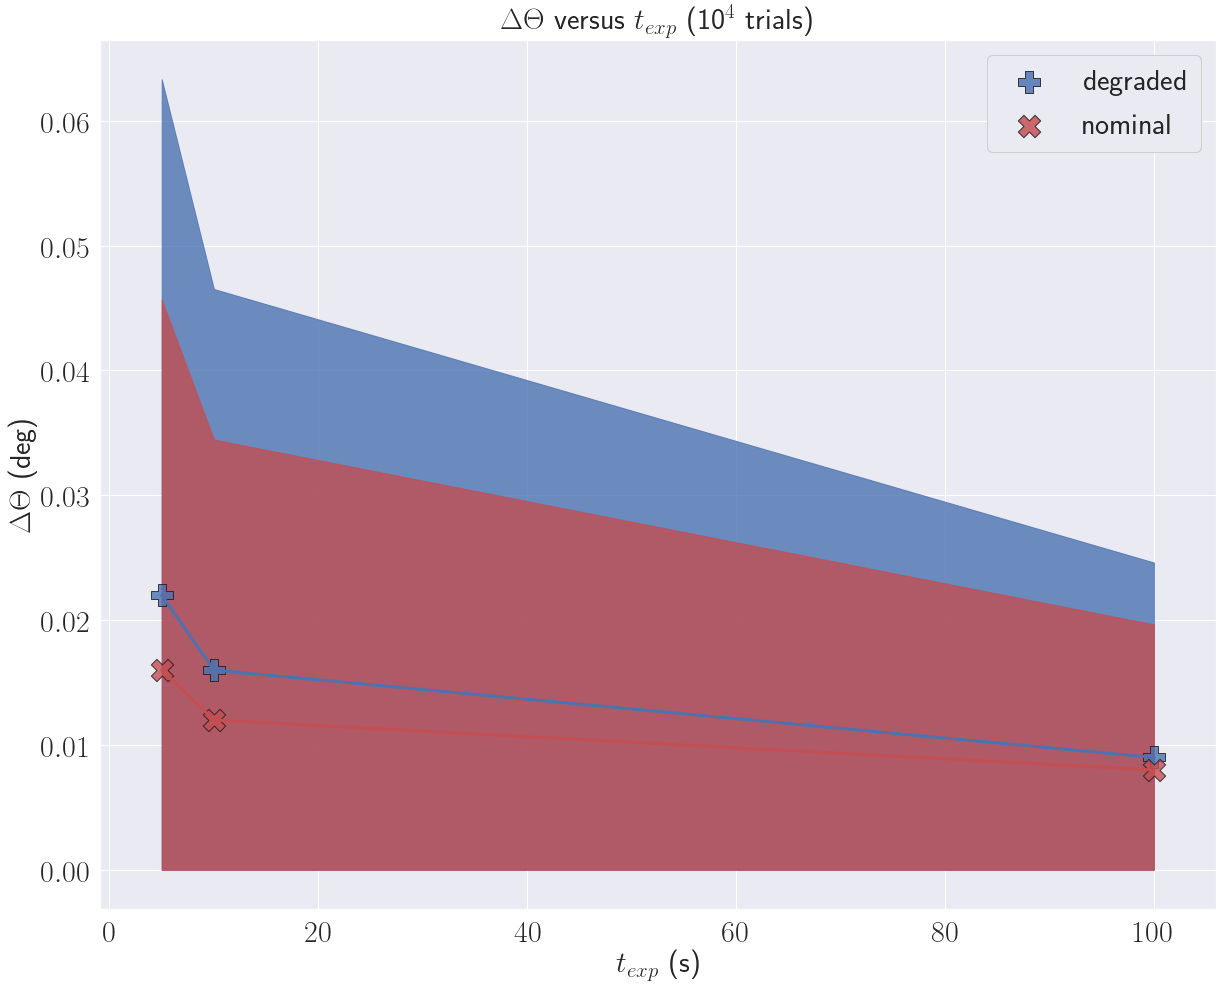

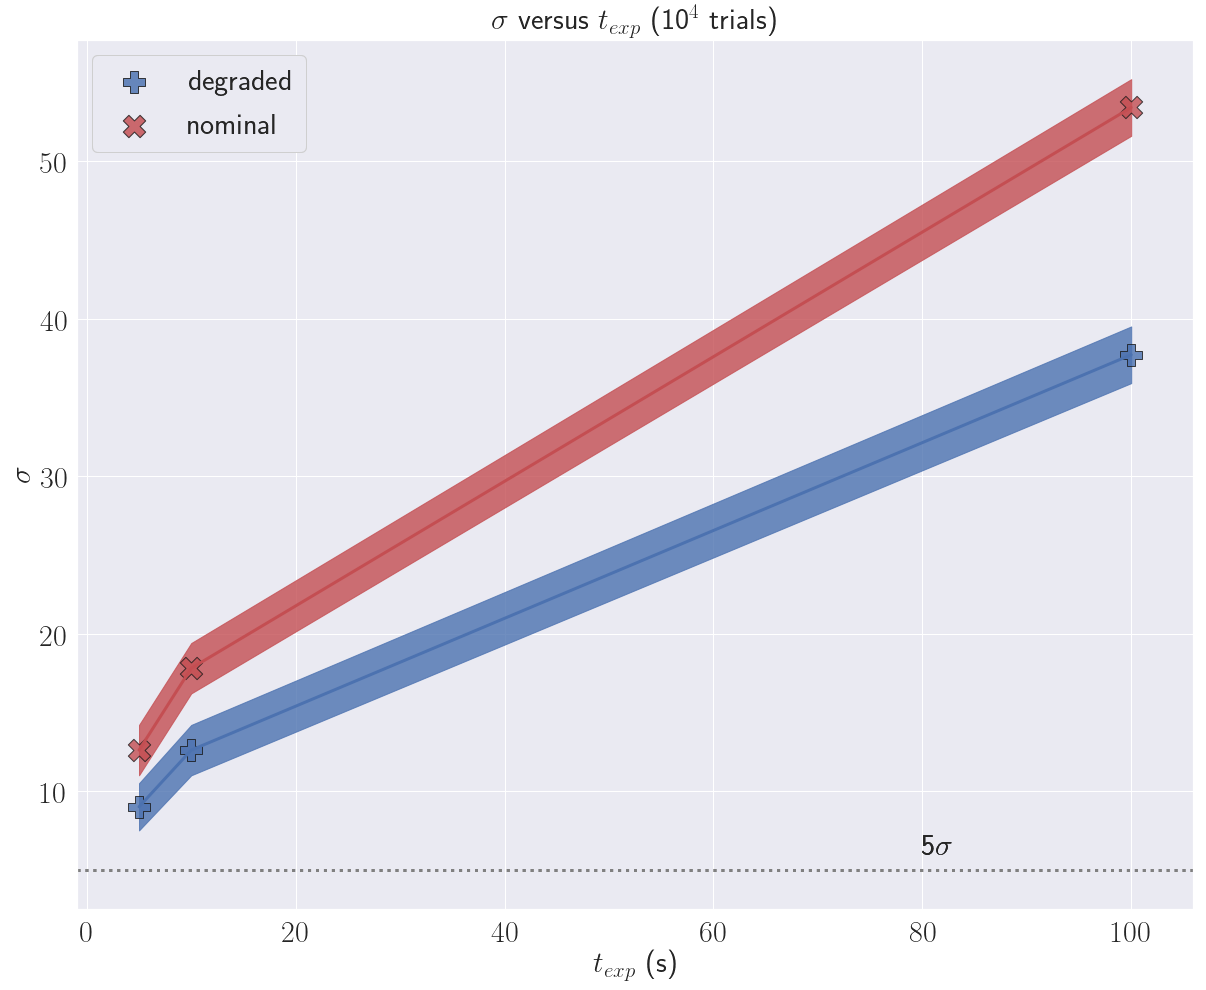

In [113]:
png_path = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_03_intermediate/png/'
if not os.path.isdir(png_path):
    os.system('mkdir ' + png_path)

plottage3(texp, [pos,pos2], [std_pos,std_pos2], png_path+'alltexp')
plottage3(texp, [ts,ts2], [std_ts,std_ts2], png_path+'sigma', limit=False)

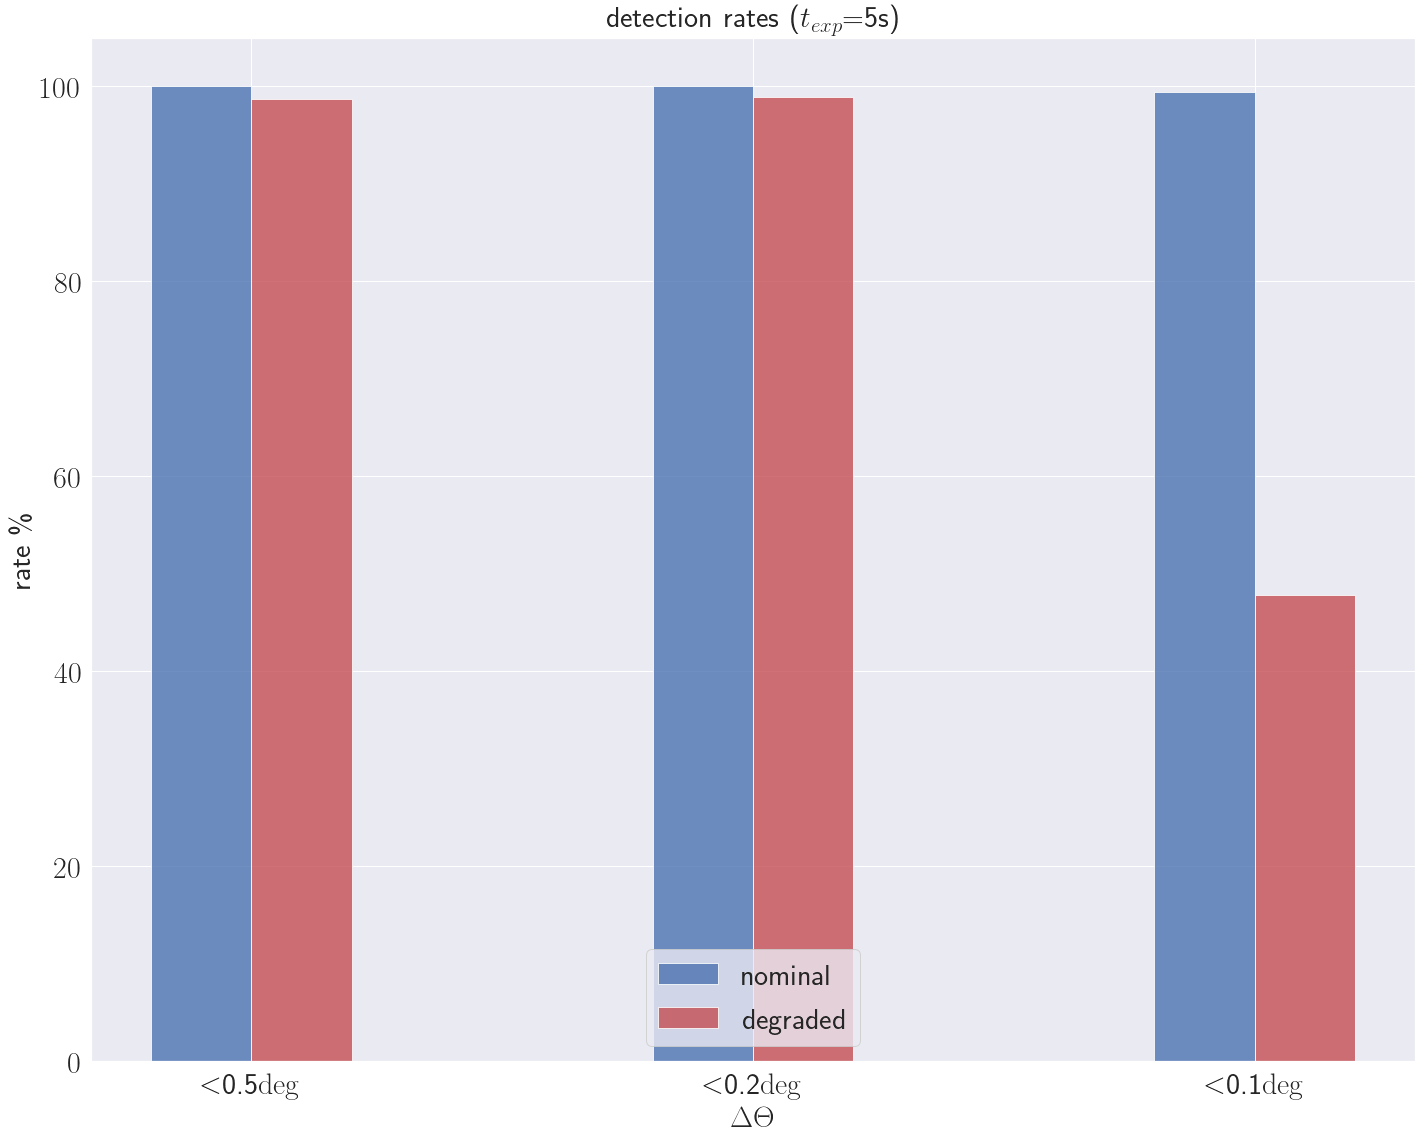

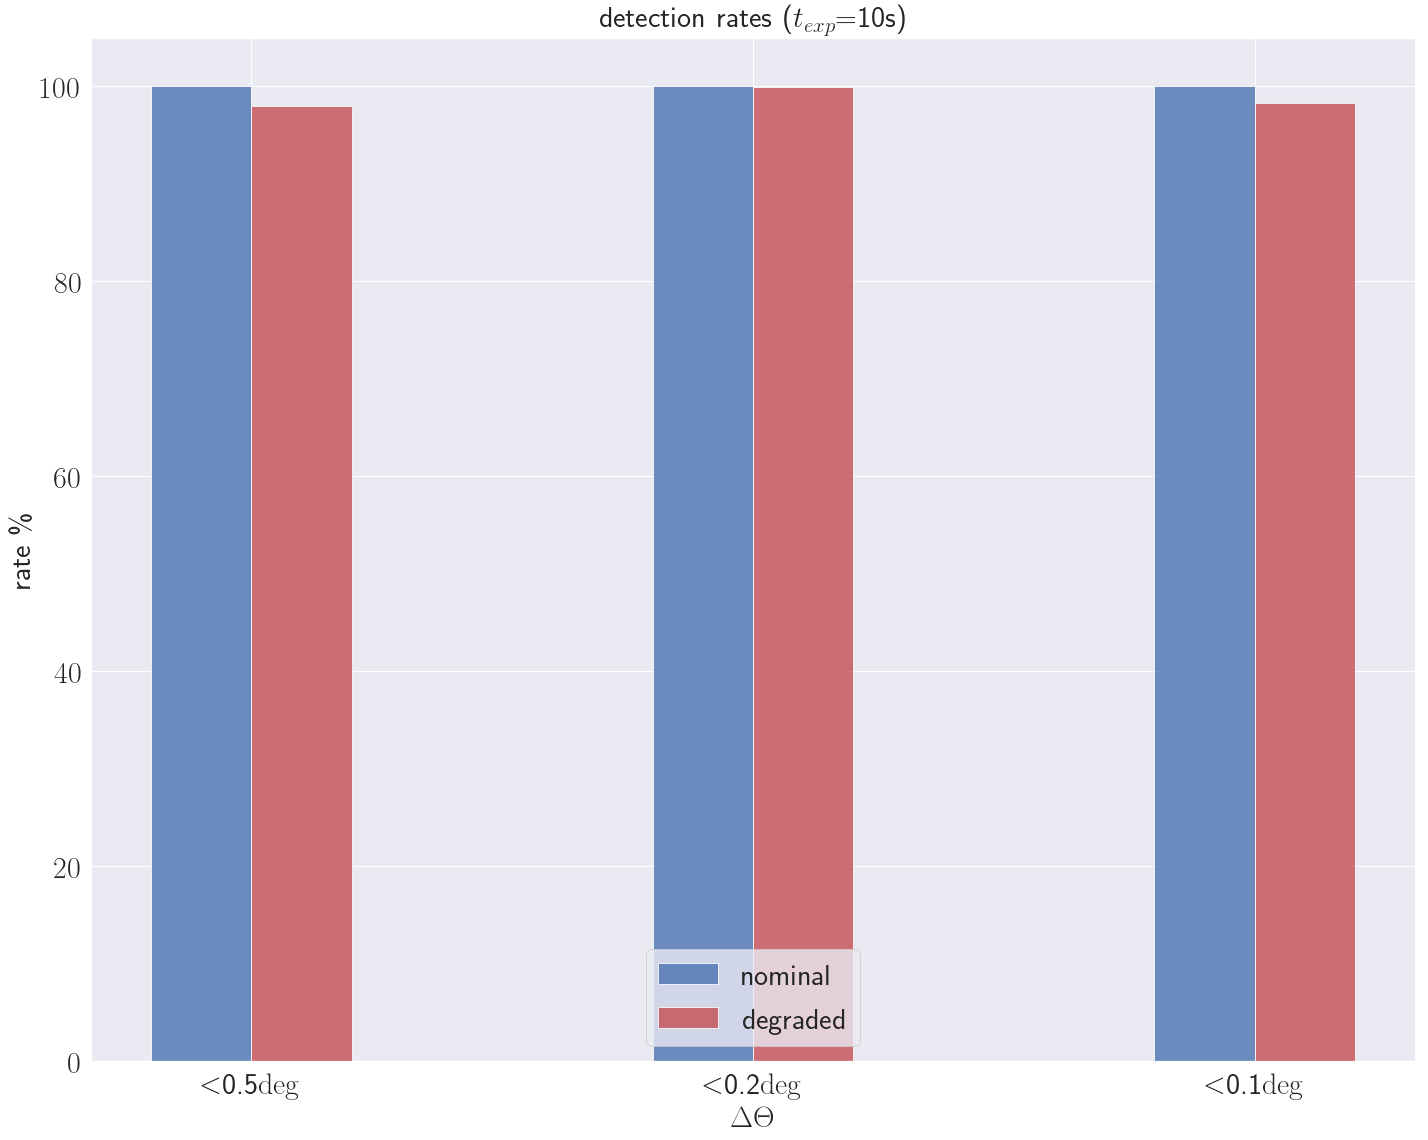

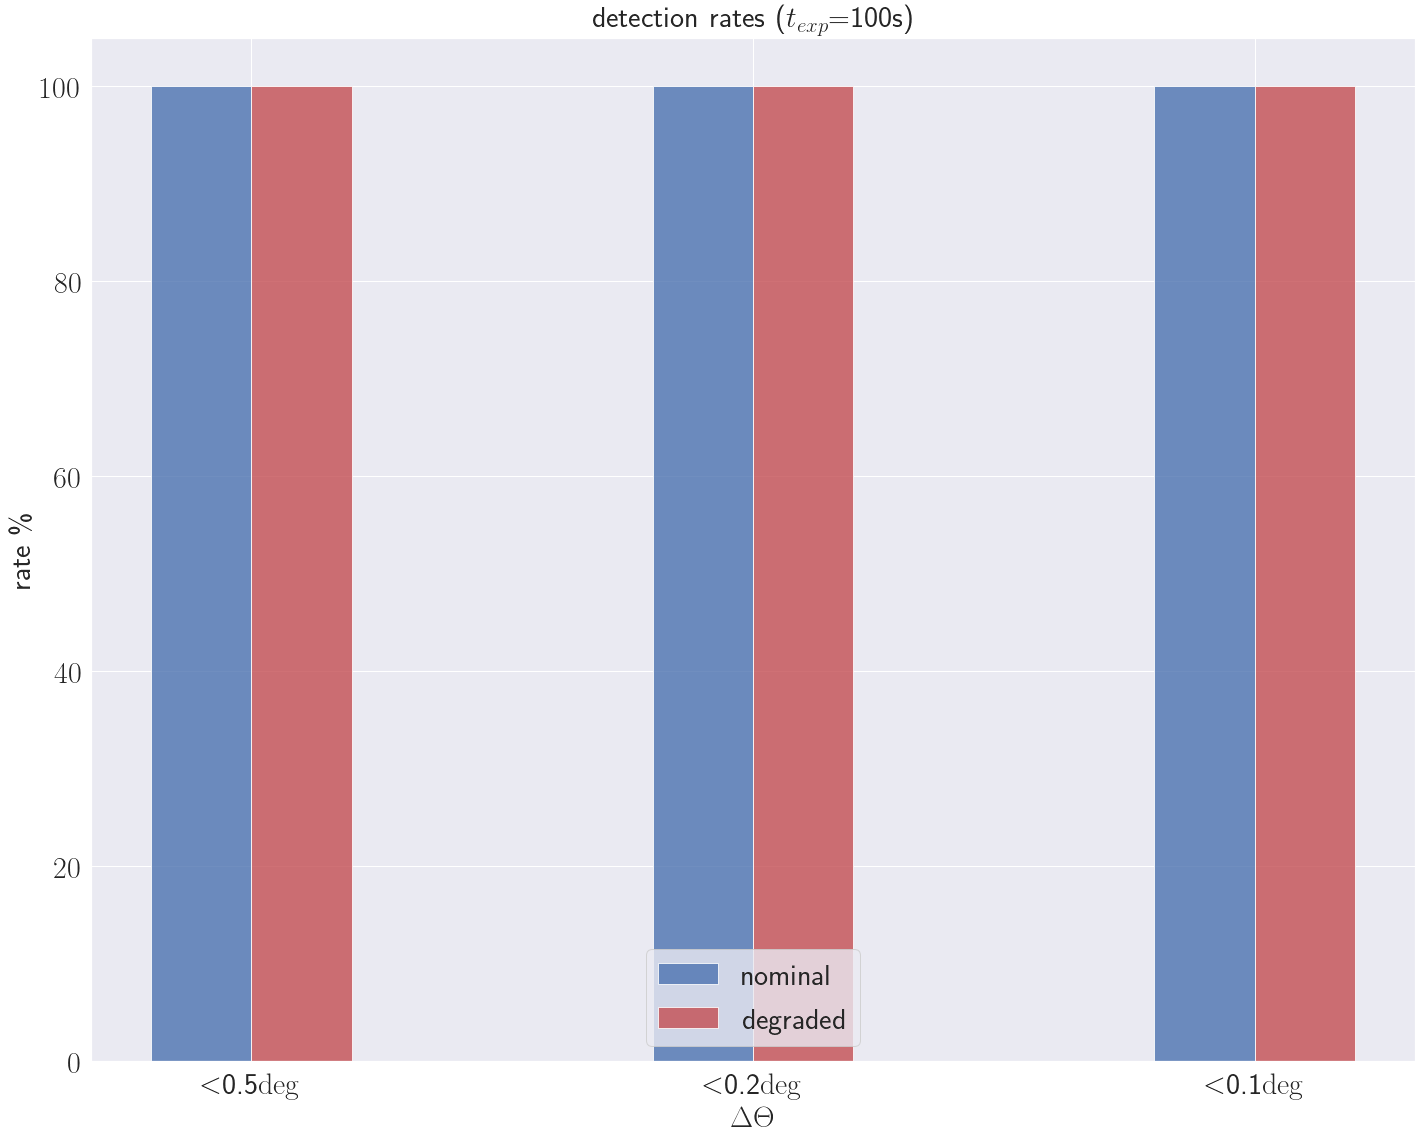

In [75]:
# data to plot
n_groups = 3

# rates 1, 5, 10, 100s (theta < [0.5, 0.2, 0.1]) ---!
nom = [[99.98, 99.98, 99.39], [100, 100, 100], [100, 100, 100]]
deg = [[98.69, 98.9, 47.81], [97.96, 99.96, 98.31], [100, 100, 100]]

# create plot
bar_width = 0.2
bar_sep = 0.5
opacity = 0.8
figsize=(20, 16)
fontsize=30

index = [np.arange(3), np.arange(3)+bar_width, np.arange(3)+bar_width*2]

for n in range(len(texp)):
    fig = plt.figure(figsize=figsize)
    plt.rc('text', usetex=True)
    sns.set()
    
    ax = plt.subplot(111)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    rects1 = plt.bar(index[0], nom[n], bar_width,
                     alpha=opacity, color='b', label='nominal')
    rects2 = plt.bar(index[1], deg[n], bar_width,
                     alpha=opacity, color='r', label='degraded')

    plt.xlabel('$\Delta$$\Theta$', fontsize=fontsize)
    plt.ylabel('rate \%', fontsize=fontsize)
    plt.title('detection rates ($t_{exp}$=%ds)' %texp[n], fontsize=fontsize)
    plt.xticks(index[1]-0.1, ('$<$0.5$\deg$', '$<$0.2$\deg$', '$<$0.1$\deg$'))
    plt.legend(loc='lower center', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(png_path+'rates_texp%ds.png' %texp[n])
    plt.show()
    plt.close()


tesi_intermediate_nominal_EBL/

================ texp = 5s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9999
! NaN DETECTION RATE : 0.010000000000005116 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.98 %
~ ra det mean: 33.05751691716006 ra det std: 0.02586848964636355
~ dec det mean: -51.84072992386052 dec det std: 0.01599454437165614
~ pos det mean: 0.02005212295664845 pos det gamma: 0.015991423031977155
~ flux fit mean: 5.8814743598004695e-09 flux fit std: 1.0766620631817957e-09
~ ts fit mean: 12.633427779144851 ts fit std: 1.644728845498973


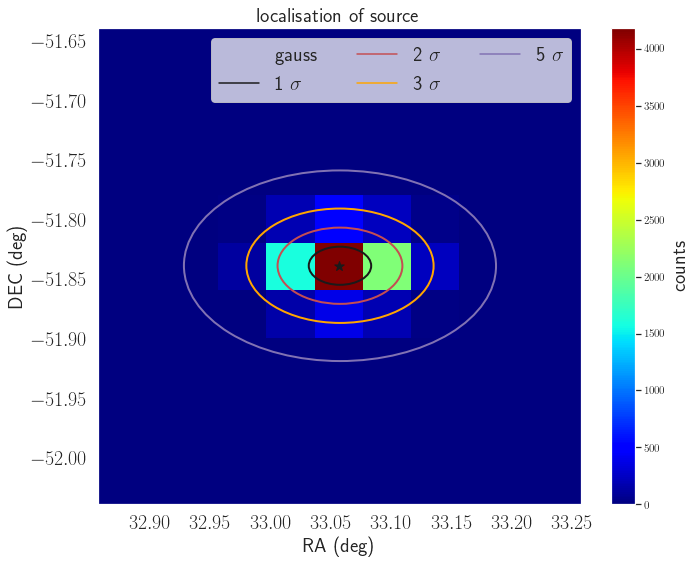

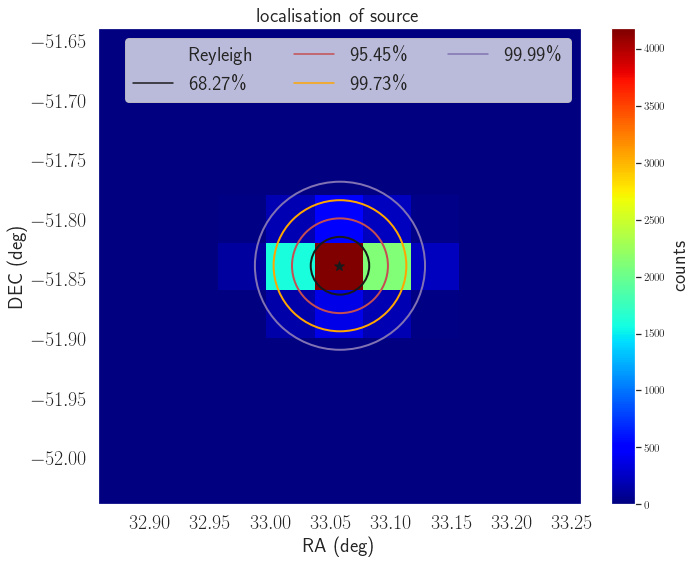


================ texp = 10s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.057158219738035 ra det std: 0.019193468797232216
~ dec det mean: -51.84086399472577 dec det std: 0.01204048110890466
~ pos det mean: 0.01525253552724772 pos det gamma: 0.011950494871775777
~ flux fit mean: 5.858749971108213e-09 flux fit std: 7.702590237500986e-10
~ ts fit mean: 17.847954520330937 ts fit std: 1.6567783618210619


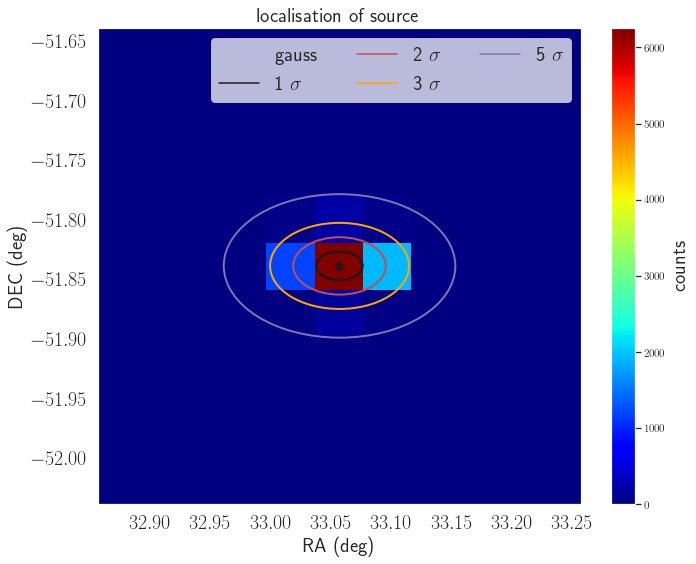

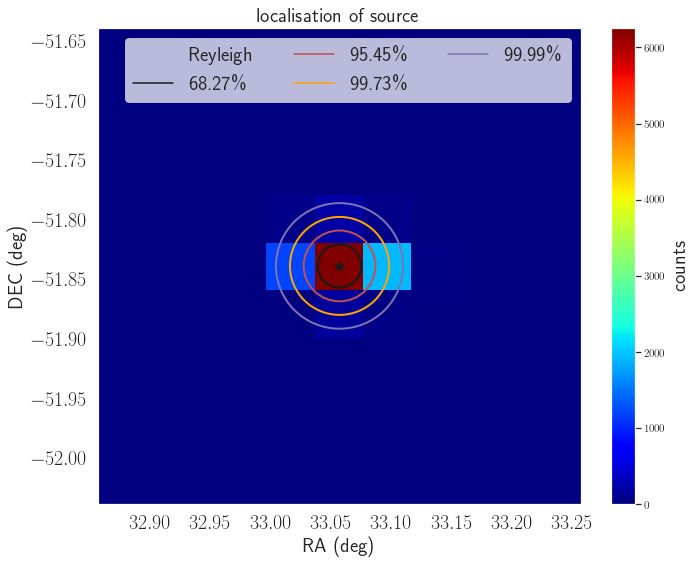


================ texp = 100s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05542795234129 ra det std: 0.0066324767387675974
~ dec det mean: -51.84042133547179 dec det std: 0.009925806620942421
~ pos det mean: 0.01052974350615409 pos det gamma: 0.0076351975470433245
~ flux fit mean: 5.37959117805734e-09 flux fit std: 2.832066388963101e-10
~ ts fit mean: 53.38017327100637 ts fit std: 1.782232155847894


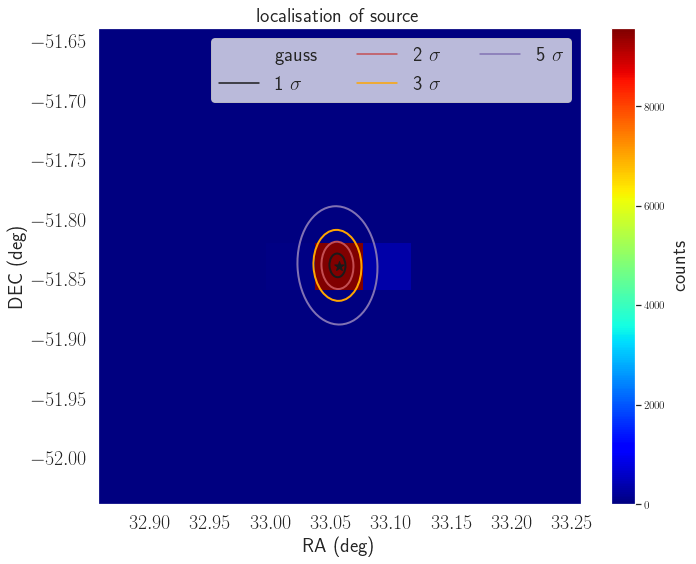

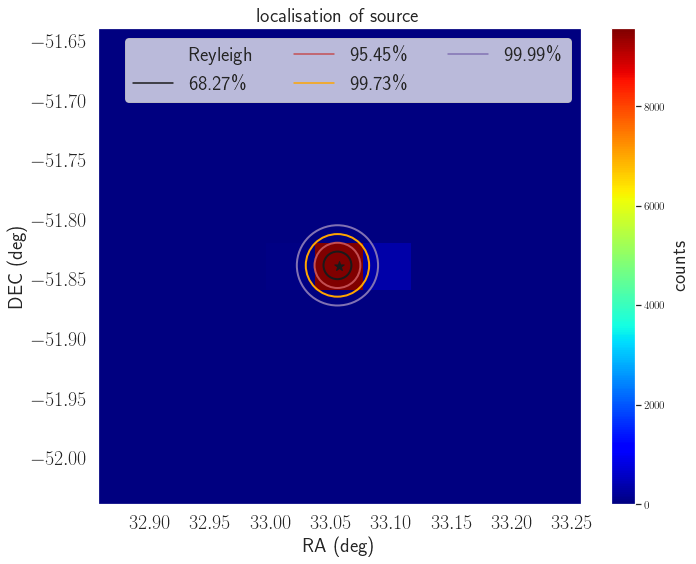

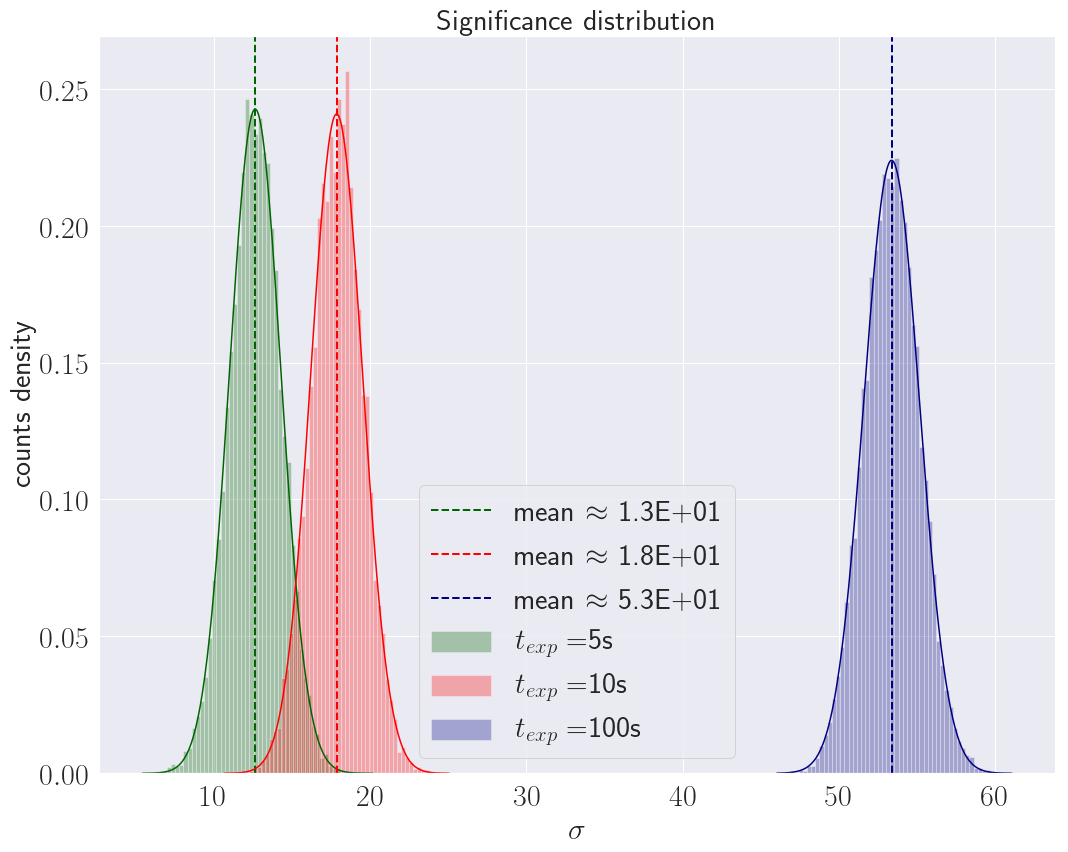

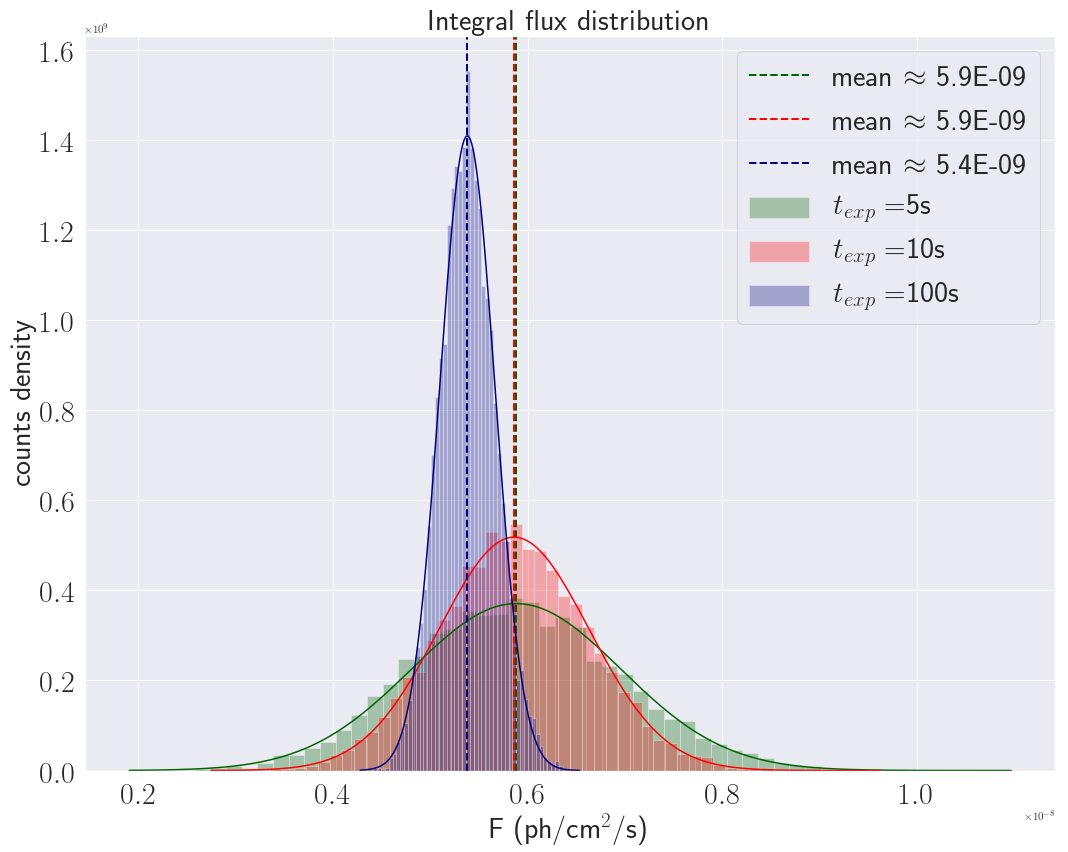


tesi_intermediate_degraded_EBL/

================ texp = 5s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  9923
! NaN DETECTION RATE : 0.7700000000000102 %


/home/ambra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in sqrt


! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 97.28 %
~ ra det mean: 33.057313568278325 ra det std: 0.035711398353629194
~ dec det mean: -51.84063187801039 dec det std: 0.022116054840821534
~ pos det mean: 0.02728317406127146 pos det gamma: 0.02209200376524804
~ flux fit mean: 5.951538014511107e-09 flux fit std: 1.4774158607089565e-09
~ ts fit mean: 8.997527985320255 ts fit std: 1.5649106473852972


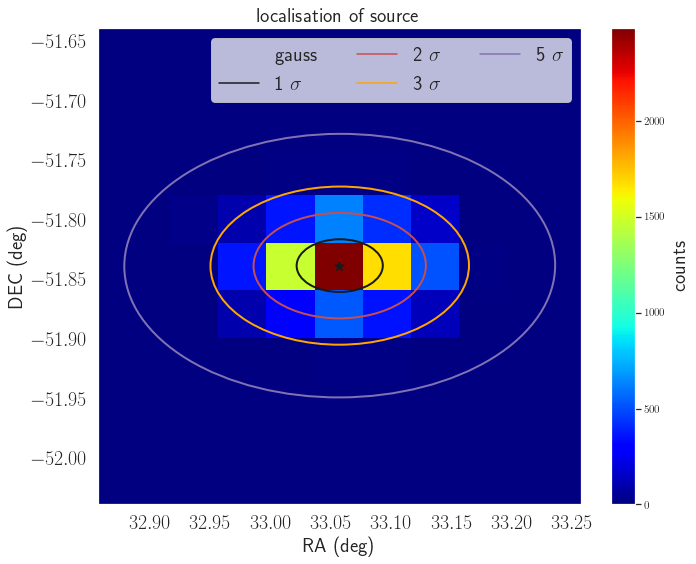

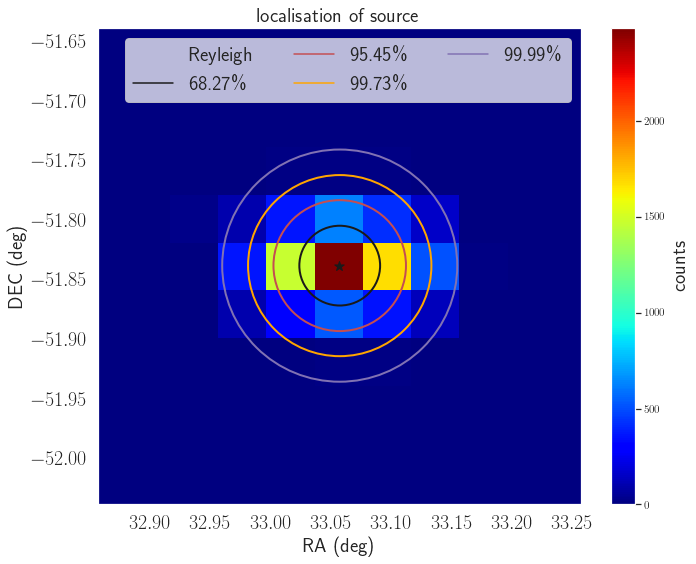


================ texp = 10s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 99.96000000000001 %
~ ra det mean: 33.057366186786396 ra det std: 0.026473733625245344
~ dec det mean: -51.84055943092667 dec det std: 0.016348993160070248
~ pos det mean: 0.020403906088126002 pos det gamma: 0.016356667831011872
~ flux fit mean: 5.871074548412298e-09 flux fit std: 1.0923322697028886e-09
~ ts fit mean: 12.62306298286476 ts fit std: 1.6549859242969702


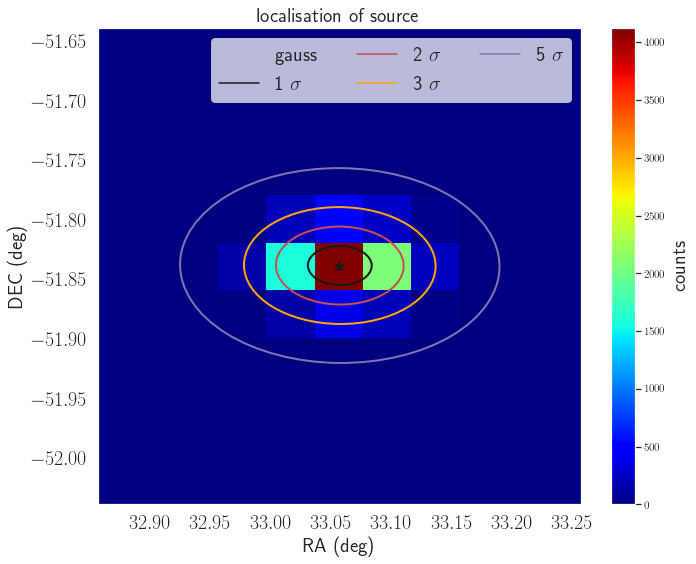

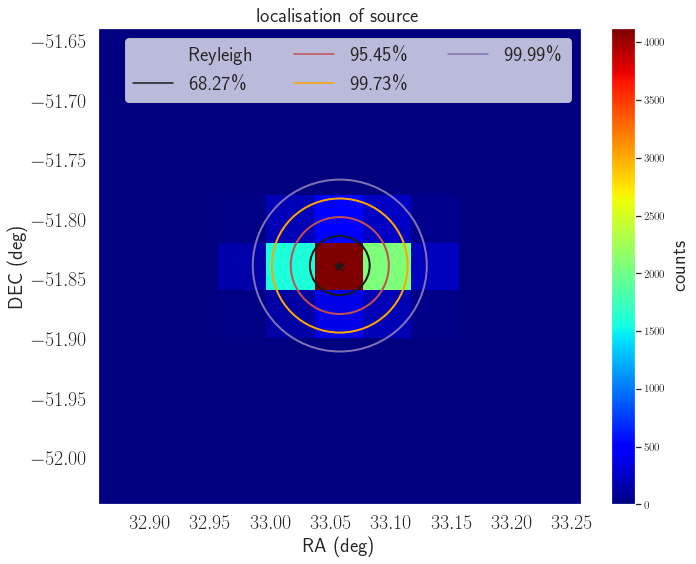


================ texp = 100s ==============

* verify trials =  10000
* drop duplicate => trials =  10000
* drop nan => trials =  10000
! NaN DETECTION RATE : 0.0 %
! DET RATIO WITHIN 0.5deg FROM TRUE POSITION: 100.0 %
~ ra det mean: 33.05646774573081 ra det std: 0.01220433564665176
~ dec det mean: -51.84063969033849 dec det std: 0.010092476883757482
~ pos det mean: 0.01183324266939043 pos det gamma: 0.008914990550636416
~ flux fit mean: 5.383014795731499e-09 flux fit std: 3.982943478073096e-10
~ ts fit mean: 37.742902858755926 ts fit std: 1.800135937787347


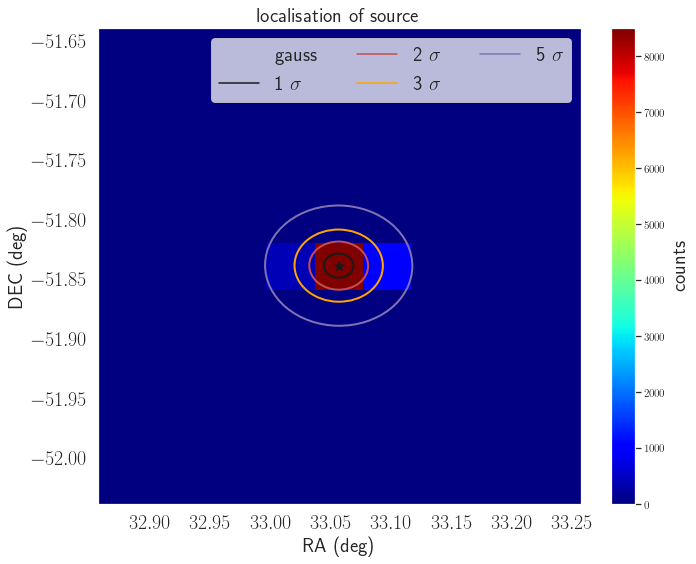

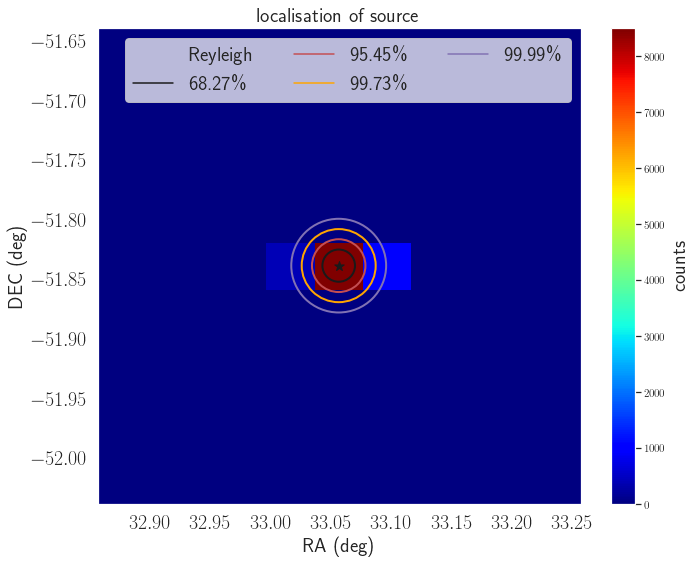

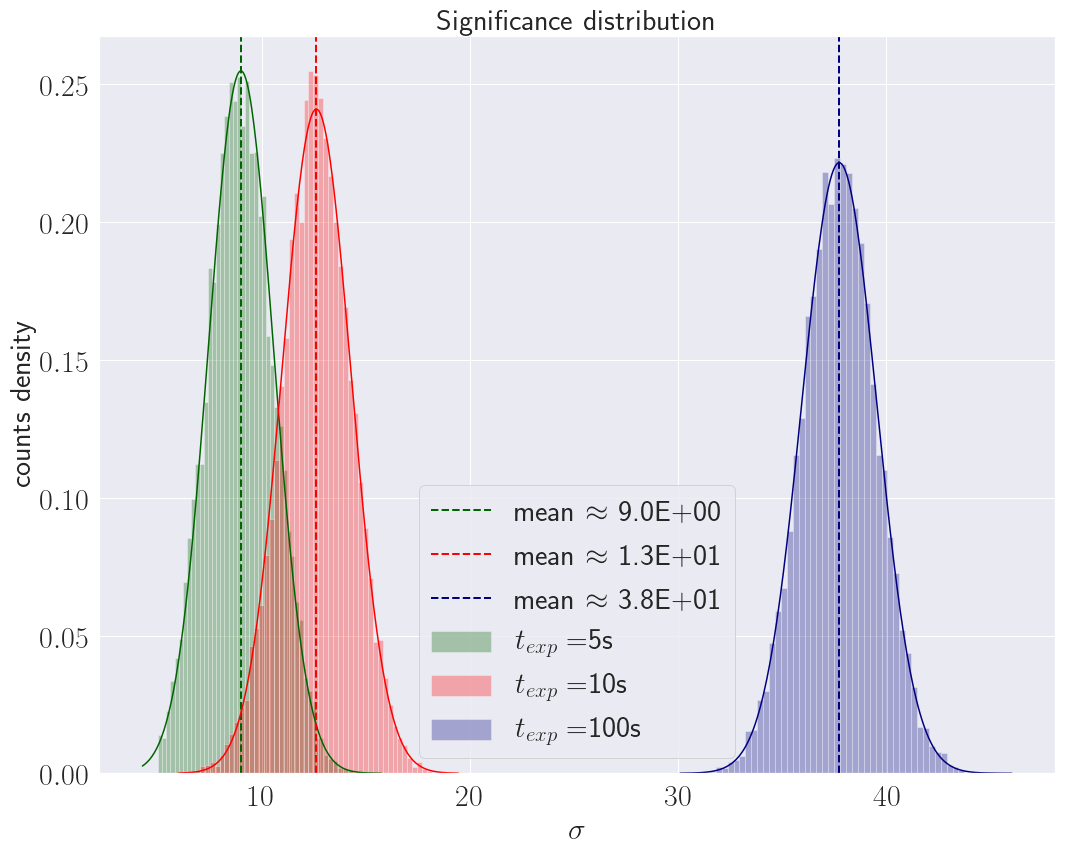

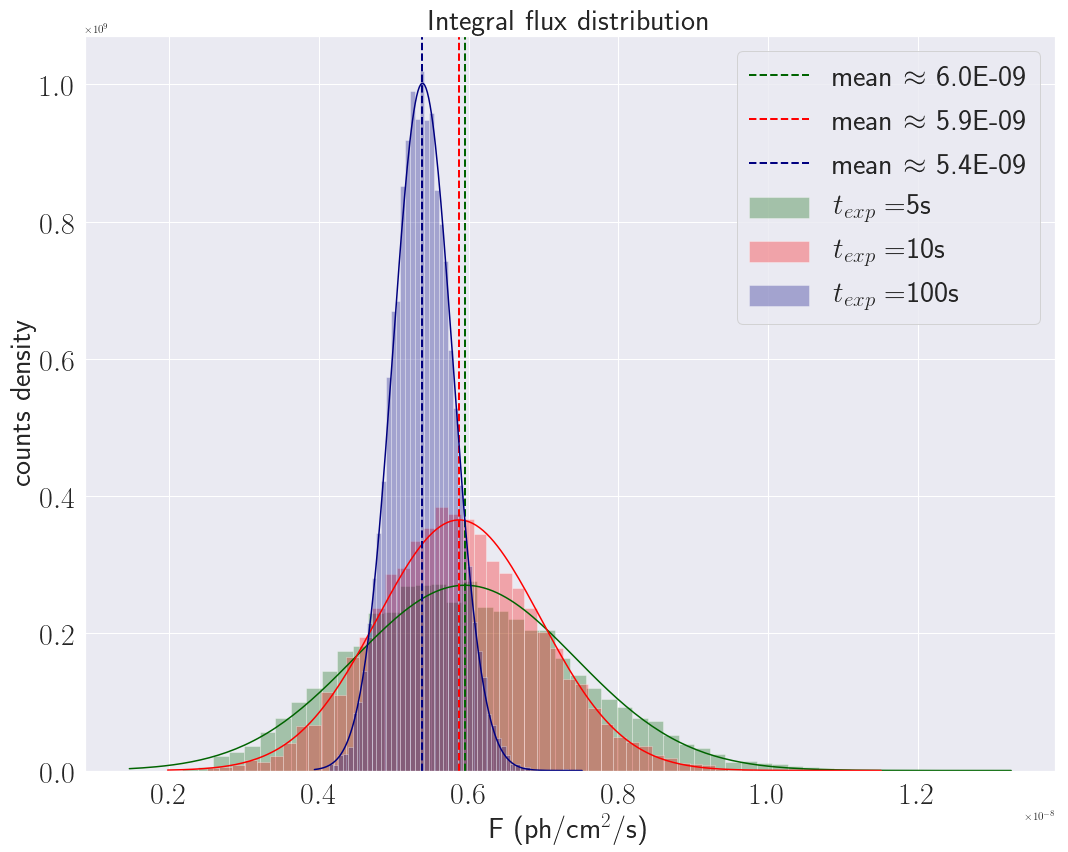

done


In [7]:
# =============================
# !!! ALL STATISTICAL PLOTS !!!
# =============================

import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('/home/ambra/Desktop/cluster-morgana/')
from module_statistics import *

png_path = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_01_preliminary/png/'
if not os.path.isdir(png_path):
    os.system('mkdir ' + png_path)

for index, f in enumerate(folders):
    print('\n' + f)
    path = directory + f + 'run0406/run0406_ID000126/csv/'
    png_path = directory + f + 'png/'
    if not os.path.isdir(png_path):
        os.mkdir(png_path)

    list_ts, list_flux, list_pos = ([] for j in range(3))
    list_mean_ts, list_mean_flux = ([] for j in range(2))
    list_std_ts, list_std_flux = ([] for j in range(2))

    for n in range(len(texp)) :  
        # store values ---!
        filename = csvMerged[n]
        print('\n================ texp = %ds ==============\n' %texp[n])

        # load DataFrame and column names ---!
        df = pd.read_csv(path+filename)
        cols = list(df.columns)
        trials = len(df[cols[0]])
        print('* verify trials = ', trials)  
        # drop duplicates ---! 
        df.sort_values(cols[0], inplace = True) 
        # dropping ALL duplicte values 
        df.drop_duplicates(subset=cols[0], keep='last', inplace=True) 
        trials = len(df[cols[0]])
        print('* drop duplicate => trials = ', trials) 
        total = trials
        # drop NaN ---!
        df = df.dropna()
        trials = len(df[cols[0]])
        df = df.reindex(np.arange(trials))
        print('* drop nan => trials = ', trials)  
        # set arrays ---!
        # 0      1     2      3     4     5       6        7       8        9        10/-1  
        # trial, texp, sigma, Ndet, Nsrc, RA_det, DEC_det, RA_fit, DEC_fit, flux_ph, TS
        ts = np.array(df[cols[-1]]) 
        trials = len(ts)
        df = df.reindex(np.arange(trials))
        perc = 100 * (trials/total)
        print('! NaN DETECTION RATE :', 100-perc, '%')

        trial = np.array(df[cols[0]])
        raDet = np.array(df[cols[5]])
        decDet = np.array(df[cols[6]])
        flux = np.array(df[cols[9]])
        ts = np.sqrt(np.array(df[cols[-1]]))

        # DETECTION ---!
        distance_det = []
        d_det = []
        ra_det = []
        dec_det = []
        flux_fit = []
        ts_fit = []

        for i in range(len(raDet)) :
            if ts[i]>=ts_threshold:
                if -90 <= decDet[i] and decDet[i] <= 90 and 0 <= raDet[i] and raDet[i] <= 360 :
                    det_coord = SkyCoord(ra = raDet[i]*u.deg, dec = decDet[i]*u.deg, frame='fk5')
                    dist = float(true_coord.separation(det_coord).deg)
                    distance_det.append(dist)                  

                    if dist <= threshold:
                        d_det.append(dist)
                        ra_det.append(raDet[i]) 
                        dec_det.append(decDet[i]) 
                        flux_fit.append(flux[i])
                        ts_fit.append(ts[i])
                    
        perc_det = len(d_det)/total * 100
        print('! DET RATIO WITHIN %.1fdeg FROM TRUE POSITION:' %threshold, perc_det, '%')

        # MEAN DET ---!
        mean_raDet = np.nanmean(ra_det)
        std_raDet = np.nanstd(ra_det)
        mean_decDet = np.nanmean(dec_det)
        std_decDet = np.nanstd(dec_det)
        mean_posDet = np.nanmean(d_det)

        tmp = 0
        for i in range(len(d_det)) :
            tmp += d_det[i]**2

        if len(d_det) != 0.0 :
            mode_det = np.sqrt(1/(2*len(d_det)) * tmp)   
            MLE_det = 0.606/mode_det
        else:
            mode_det = np.nan
            MLE_det = np.nan

        print('~ ra det mean:', mean_raDet, 'ra det std:', std_raDet)
        print('~ dec det mean:', mean_decDet, 'dec det std:', std_decDet)
        print('~ pos det mean:', mean_posDet, 'pos det gamma:', mode_det)


        # MAX LIKELIHOOD ---! 
        mean_ts = np.nanmean(ts_fit)
        std_ts = np.nanstd(ts_fit)   
        mean_flux = np.nanmean(flux_fit)
        std_flux = np.nanstd(flux_fit)

        print('~ flux fit mean:', mean_flux, 'flux fit std:', std_flux)
        print('~ ts fit mean:', mean_ts, 'ts fit std:', std_ts)
        
        mappage(ra_det, dec_det, mode_det, trueRA, trueDEC, texp[n])
        
        list_ts.append(ts_fit)
        list_mean_ts.append(mean_ts)
        list_std_ts.append(std_ts)
        list_flux.append(flux_fit)
        list_mean_flux.append(mean_flux)
        list_std_flux.append(std_flux)
        
    plottage(texp, list_ts, list_flux, list_std_ts, list_std_flux, list_mean_ts, list_mean_flux, png_path)
print('done')

In [ ]:
# ------------------------------------------ plots ---!
c = ['darkgreen', 'red', 'navy', 'gold']
l_ra = ['texp=%ds, $\sigma$=%.3f' %(texp[i], list_std_ra[i][0]) for i in range(len(texp))]
l_dec = ['texp=%ds, $\sigma$=%.3f' %(texp[i], list_std_dec[i][0]) for i in range(len(texp))]
l_pos = ['texp=%ds, $\gamma$=%.3f' %(texp[i], list_modes[i][0]) for i in range(len(texp))]
alpha = 0.1
    
# DETECTION 1D ---!
fig, ax = hist1d_gauss(list_ra, mean=None, loc=trueRA, threshold=threshold, nbin=Dnbin, width=Dwidth,
                       fontsize=fontsize, color=c, alpha=alpha, hist=False,
                       title='detected RA distribution', leglabel=l_ra,
                       xlabel='RA (deg)', ylabel='counts density',
                       filename=png_path+'run0406_detRA.png')   
plt.show()
plt.close()

fig, ax = hist1d_gauss(list_dec, mean=None, loc=trueDEC, nbin=Dnbin, width=Dwidth,
                       threshold=threshold, fontsize=fontsize, color=c, alpha=alpha,
                       title='detected DEC distribution', leglabel=l_dec, hist=False, 
                       xlabel='DEC (deg)', ylabel='counts density',
                       filename=png_path+'run0406_detDEC.png') 
plt.show()
plt.close()

fig, ax = hist1d_rayleigh(list_pos, mean=None, rayleigh_prms={'loc':0, 'scale':None}, 
                          threshold=threshold, nbin=Dnbin, width=Dwidth, fontsize=fontsize, 
                          color=c, alpha=alpha, leglabel=l_pos, hist=False,
                          title='detected $\\Delta \\Theta$ distribution',
                          xlabel='$\\Delta \\Theta$ (deg)', ylabel='counts density',
                          filename=png_path+'run0406_detPOS.png')
plt.show()
plt.close()


    
    
    
print('\n\nok')